In [1]:
from data import prepare_dataloaders
from models.linear import NLinear, DLinear
from constants import Config
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import lightning as L
import numpy as np
from eval import average_predictions, plot_reconstructed

In [37]:
seq_len = 24
pred_len = 96
n_channels = 3

train_loader, val_loader, test_loader = prepare_3d_dataloaders(batch_size=8, seq_len=seq_len, pred_len=pred_len, n_channels=n_channels)

nlinear = NLinear(Config(seq_len=seq_len, pred_len=pred_len, n_channels=n_channels))
nlinear.cuda()


preparing data3d...
done preparing data3d


NLinear(
  (linear): ModuleList(
    (0-2): 3 x Linear(in_features=24, out_features=96, bias=True)
  )
)

In [38]:
tli = iter(train_loader)
for i in range(100):
    batch = next(tli)
x,y = batch
x = x.cuda()
y = y.cuda()
x.shape,y.shape

(torch.Size([8, 24, 3]), torch.Size([8, 96, 3]))

In [12]:
y_hat = nlinear.forward(x)
y_hat.shape

torch.Size([8, 1, 3])

In [13]:
y

tensor([[[  1.0724, 333.4085,  19.7509]],

        [[  1.1286, 338.2799,  20.3234]],

        [[  1.1276, 334.9824,  20.9630]],

        [[  1.1178, 332.3256,  20.4907]],

        [[  1.1132, 327.2790,  19.2461]],

        [[  1.1254, 319.8542,  18.1337]],

        [[  1.0870, 323.3980,  17.5411]],

        [[  1.1297, 324.8519,  17.7253]]], device='cuda:0',
       dtype=torch.float64)

In [14]:
y_hat

tensor([[[  1.2881, 339.2560,  21.0322]],

        [[  1.2657, 338.4501,  20.7917]],

        [[  1.2797, 337.7162,  20.5053]],

        [[  1.2967, 321.5578,  20.2981]],

        [[  1.2974, 326.4244,  20.1478]],

        [[  1.2940, 338.3836,  20.4075]],

        [[  1.2718, 344.6643,  21.0154]],

        [[  1.2846, 347.5431,  21.3955]]], device='cuda:0',
       dtype=torch.float64, grad_fn=<AddBackward0>)

In [15]:
F.mse_loss(y_hat, y)

tensor(62.6138, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

In [45]:

nlinear = NLinear(Config(seq_len=seq_len, pred_len=pred_len, n_channels=n_channels))
nlinear.cuda()

losses = []
optimizer = torch.optim.Adam(nlinear.parameters(), lr=1e-4)

for _ in range(20):

    print(len(nlinear.training_step_losses))

    tli = iter(train_loader)
    while True:
        batch = next(tli, None)
        if batch is None:
            break
        optimizer.zero_grad()
        loss = nlinear.training_step(batch, 0)
        loss.backward()
        optimizer.step()

    print(len(nlinear.training_step_losses))
    _losses = [e.item() for e in nlinear.training_step_losses]
    loss = sum(_losses) / len(_losses)
    losses.append(loss)
    nlinear.training_step_losses.clear()

0


c:\Users\nak-o\miniconda3\envs\ds\lib\site-packages\lightning\pytorch\core\module.py:407: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270


In [46]:
losses

[296.69031417605913,
 270.22497621021614,
 266.0020441246135,
 263.8768211823139,
 262.55232802795774,
 261.6370972562828,
 260.96129486103877,
 260.4380749649951,
 260.0185610688298,
 259.6731910848716,
 259.38298707801454,
 259.1351408476789,
 258.920641095937,
 258.7329275016804,
 258.5670889212923,
 258.4193638960889,
 258.2868167079619,
 258.1671196771408,
 258.0584022669484,
 257.95914368944756]

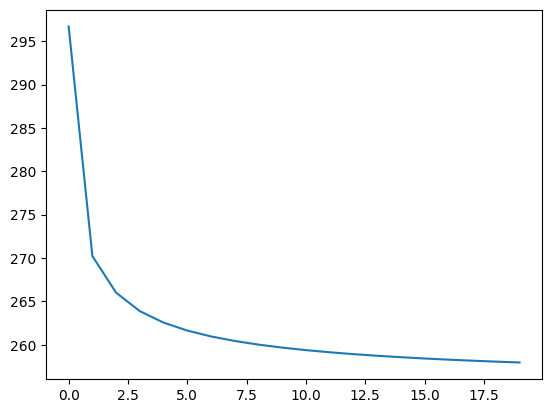

In [47]:
plt.plot(range(len(losses)), losses)

In [31]:
losses = [e.item() for e in nlinear.training_step_losses]

In [32]:
sum(losses)/len(losses)

35.58397290443858

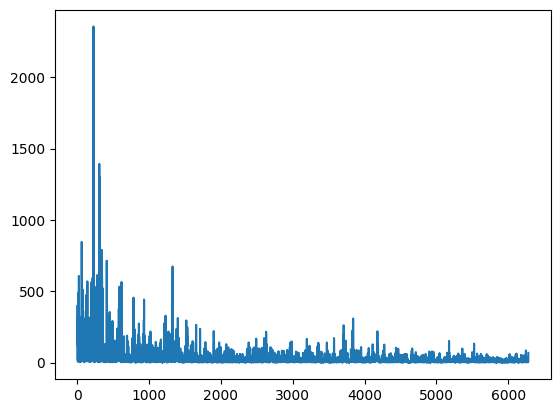

In [33]:
plt.plot(range(len(losses)), losses)

# tensorboard event

In [3]:
from tensorboard.backend.event_processing import event_accumulator

ea = event_accumulator.EventAccumulator(
    r'D:\uog\disertation\exp\dlinear\1d\H24-T96\loss_val\events.out.tfevents.1687570726.nack.4576.1'
)

ea.Reload()


In [4]:
ea.Tags()

{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': ['loss'],
 'distributions': [],
 'tensors': [],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

In [5]:
ea.Scalars('loss')

[ScalarEvent(wall_time=1687570726.3233154, step=0, value=1.5767239332199097),
 ScalarEvent(wall_time=1687570729.0126238, step=0, value=1.0992387533187866),
 ScalarEvent(wall_time=1687570731.6101084, step=1, value=0.9458358287811279)]

In [6]:
se = ea.Scalars('loss')[0]
se

ScalarEvent(wall_time=1687570726.3233154, step=0, value=1.5767239332199097)

In [7]:
se.value

1.5767239332199097

# pred

In [2]:
H = 24
T = 96
batch_size = 32
data = '1d'
model = 'nlinear'

checkpoint_path = r"D:\uog\disertation\exp\nlinear\1d\H24-T96\checkpoints\nlinear-epoch=19-val_loss=1.1573.ckpt"

_, _, test_loader, scaler = prepare_dataloaders(
    data, 
    batch_size=batch_size,
    seq_len=H,
    pred_len=T,
    n_channels=3
)

config = Config(seq_len=H, pred_len=T, n_channels=3, lr=1e-3)

model = NLinear(config)
model.load_from_checkpoint(checkpoint_path, config=config)
model.eval()
model.freeze()

trainer = L.Trainer()
predictions = trainer.predict(model, test_loader)

GPU available: True (cuda), used: True


yeah len(test_y) 12571


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\nak-o\miniconda3\envs\ds\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 393/393 [00:01<00:00, 197.30it/s]


In [37]:
len(predictions), predictions[0].shape

(393, torch.Size([32, 96, 3]))

In [38]:
batch_x,batch_y = next(iter(test_loader))
batch_x.shape, batch_y.shape

(torch.Size([32, 24, 3]), torch.Size([32, 96, 3]))

In [27]:
batch_y[0]

tensor([[ 0.2208, -0.1139, -0.1907],
        [ 0.5294, -0.0754, -0.3136],
        [ 0.4680, -0.0529, -0.2235],
        [ 0.5509, -0.0281,  0.0154],
        [ 0.3958,  0.0583,  0.1236],
        [ 0.6992,  0.1732,  0.1734],
        [ 0.7203,  0.2128,  0.1650],
        [ 0.0896,  0.3287,  0.2446],
        [ 0.1468,  0.4539,  0.2291],
        [ 0.4342,  0.5731,  0.3647],
        [ 0.4117,  0.6285,  0.5518],
        [ 0.0954,  0.6341,  0.6121],
        [ 0.1515,  0.5921,  0.5491],
        [ 0.2360,  0.5052,  0.3964],
        [ 0.3801,  0.5014,  0.2980],
        [ 0.0521,  0.4686,  0.1733],
        [ 0.3774,  0.3761,  0.1986],
        [ 0.4426,  0.3626,  0.3262],
        [ 0.3902,  0.3748,  0.3641],
        [ 0.9289,  0.4346,  0.3713],
        [ 0.1546,  0.1798,  0.4653],
        [ 0.9293,  0.1073,  0.5845],
        [ 0.4705,  0.2578,  0.5995],
        [ 0.4258,  0.3634,  0.4702],
        [ 0.1812,  0.4456,  0.4117],
        [ 0.5654,  0.4897,  0.3884],
        [-0.0839,  0.5764,  0.3747],
 

In [28]:
batch_y[1]

tensor([[ 0.5294, -0.0754, -0.3136],
        [ 0.4680, -0.0529, -0.2235],
        [ 0.5509, -0.0281,  0.0154],
        [ 0.3958,  0.0583,  0.1236],
        [ 0.6992,  0.1732,  0.1734],
        [ 0.7203,  0.2128,  0.1650],
        [ 0.0896,  0.3287,  0.2446],
        [ 0.1468,  0.4539,  0.2291],
        [ 0.4342,  0.5731,  0.3647],
        [ 0.4117,  0.6285,  0.5518],
        [ 0.0954,  0.6341,  0.6121],
        [ 0.1515,  0.5921,  0.5491],
        [ 0.2360,  0.5052,  0.3964],
        [ 0.3801,  0.5014,  0.2980],
        [ 0.0521,  0.4686,  0.1733],
        [ 0.3774,  0.3761,  0.1986],
        [ 0.4426,  0.3626,  0.3262],
        [ 0.3902,  0.3748,  0.3641],
        [ 0.9289,  0.4346,  0.3713],
        [ 0.1546,  0.1798,  0.4653],
        [ 0.9293,  0.1073,  0.5845],
        [ 0.4705,  0.2578,  0.5995],
        [ 0.4258,  0.3634,  0.4702],
        [ 0.1812,  0.4456,  0.4117],
        [ 0.5654,  0.4897,  0.3884],
        [-0.0839,  0.5764,  0.3747],
        [-0.2310,  0.7213,  0.5189],
 

In [39]:
pred_first_batch = predictions[0]
pred_first_batch.shape

torch.Size([32, 96, 3])

In [40]:
pred_first_batch[0]

tensor([[-1.8889e+00, -6.8398e-02,  1.7830e-02],
        [-1.9044e+00, -7.4398e-02, -1.5600e-01],
        [-7.6185e-01, -2.6844e-01, -1.0408e-01],
        [ 1.4050e-01,  7.8756e-02, -3.7918e-01],
        [-2.1028e+00, -5.5917e-02, -2.9815e-01],
        [-4.2042e-02, -1.7596e-01, -2.7173e-01],
        [-1.5434e+00,  1.5369e-02, -1.5337e-01],
        [-2.7555e-01, -2.7537e-02, -1.0579e-01],
        [-1.6565e+00, -3.9050e-01,  1.6582e-01],
        [-1.2537e+00, -2.1923e-01, -2.1341e-01],
        [-1.5407e+00, -2.2889e-01, -5.0705e-01],
        [-3.4354e-01,  5.9364e-02, -6.1191e-01],
        [-1.7230e+00, -3.1919e-01, -9.2232e-02],
        [-4.1314e-02, -2.0546e-01, -3.7068e-01],
        [-9.1843e-01,  2.2526e-01, -1.6921e-01],
        [ 9.3421e-02,  6.6498e-02, -2.2303e-01],
        [-2.2001e+00, -2.6854e-01, -3.0656e-01],
        [-1.5614e+00, -7.7381e-04,  1.7361e-01],
        [-1.6392e+00, -5.1514e-02, -4.1143e-01],
        [-1.7785e+00, -3.2939e-01, -1.5087e-01],
        [-5.9281e-01

In [41]:
pred_first_batch[1]

tensor([[-1.6155, -0.4306,  0.0653],
        [-1.4519, -0.2329, -0.2099],
        [-0.5603, -0.4749, -0.1335],
        [ 0.0030, -0.3292, -0.2632],
        [-1.4923, -0.4233, -0.1455],
        [ 0.0302, -0.4597, -0.1709],
        [-0.9629, -0.2226, -0.0970],
        [-0.3382, -0.4080, -0.0240],
        [-1.1106, -0.4142,  0.2603],
        [-1.0503, -0.5149, -0.1322],
        [-1.4797, -0.5873, -0.4795],
        [-0.0330, -0.1828, -0.4885],
        [-1.4236, -0.3674, -0.1728],
        [-0.1373, -0.3361, -0.2474],
        [-0.9058, -0.0596, -0.1942],
        [-0.0202, -0.1494, -0.1576],
        [-1.9723, -0.5262, -0.0992],
        [-1.0449, -0.1211,  0.0333],
        [-1.4141, -0.0619, -0.3036],
        [-1.3287, -0.3275, -0.0790],
        [-0.3663, -0.5885, -0.3551],
        [-0.1409, -0.0953, -0.2071],
        [-1.2068, -0.2175, -0.0455],
        [-0.4203, -0.2692, -0.1437],
        [-1.3666, -0.5125,  0.1484],
        [-0.6301, -0.5162, -0.0761],
        [-1.1043, -0.3636, -0.1064],
 

In [4]:
preds = []
for batch_index,batch in enumerate(predictions):
    for pred_sequence_index, pred_sequence in enumerate(batch):
        for time_step_index, time_step in enumerate(pred_sequence):
            pred_index = (batch_index * batch_size) + pred_sequence_index + time_step_index
            if pred_index >= len(preds):
                preds.append([])
            preds[pred_index].append(list(time_step))


len(preds)

12666

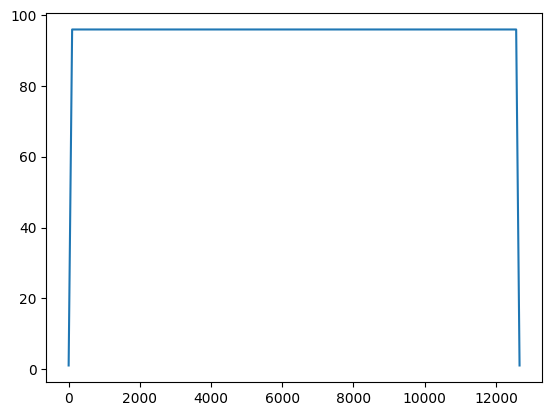

In [5]:
lengths = [len(e) for e in preds]
plt.plot(range(len(lengths)), lengths)

In [53]:
np.mean([
    [1,2],
    [3,4],
    [4,5]
], axis=0)

array([2.66666667, 3.66666667])

In [6]:
avg_preds = []
for pred in preds:
    temp = np.mean(pred, axis=0)
    avg_preds.append(temp)

np.array(avg_preds).shape

(12666, 3)

In [11]:
type(predictions)

list

In [23]:
def average_predictions(predictions: list, batch_size: int, only_first=False) -> np.ndarray:
    preds = []
    for batch_index,batch in enumerate(predictions):
        for pred_sequence_index, pred_sequence in enumerate(batch):
            for time_step_index, time_step in enumerate(pred_sequence):
                pred_index = (batch_index * batch_size) + pred_sequence_index + time_step_index
                if pred_index >= len(preds):
                    preds.append([])
                preds[pred_index].append(list(time_step))

    avg_preds = []
    for pred in preds:
        if only_first:
            temp = np.array(pred)[0,:]
        else:
            temp = np.mean(pred, axis=0)
        avg_preds.append(temp)

    return np.array(avg_preds)


In [31]:
preds = average_predictions(predictions, batch_size)

In [24]:
batch_y_list = []
for batch in test_loader:
    x,y = batch
    batch_y_list.append(y)

targets = average_predictions(batch_y_list, batch_size, only_first=True)
targets.shape

(12666, 3)

In [27]:
batch_y_list[0][0][0][0].item()

0.22081115949850885

In [26]:
targets[0:10]

array([[ 0.22081116, -0.11394513, -0.19073677],
       [ 0.52944306, -0.07540851, -0.3136283 ],
       [ 0.46796191, -0.05294528, -0.2234866 ],
       [ 0.55087822, -0.02807792,  0.01535559],
       [ 0.39581862,  0.05827985,  0.12356465],
       [ 0.69917469,  0.17321589,  0.17335976],
       [ 0.72032333,  0.21283501,  0.1649697 ],
       [ 0.08959113,  0.32867007,  0.24459381],
       [ 0.14677884,  0.45392869,  0.22910027],
       [ 0.43419681,  0.57306907,  0.36472525]])

In [17]:
batch_x,batch_y = next(iter(test_loader))
batch_y[0]

tensor([[ 0.2208, -0.1139, -0.1907],
        [ 0.5294, -0.0754, -0.3136],
        [ 0.4680, -0.0529, -0.2235],
        [ 0.5509, -0.0281,  0.0154],
        [ 0.3958,  0.0583,  0.1236],
        [ 0.6992,  0.1732,  0.1734],
        [ 0.7203,  0.2128,  0.1650],
        [ 0.0896,  0.3287,  0.2446],
        [ 0.1468,  0.4539,  0.2291],
        [ 0.4342,  0.5731,  0.3647],
        [ 0.4117,  0.6285,  0.5518],
        [ 0.0954,  0.6341,  0.6121],
        [ 0.1515,  0.5921,  0.5491],
        [ 0.2360,  0.5052,  0.3964],
        [ 0.3801,  0.5014,  0.2980],
        [ 0.0521,  0.4686,  0.1733],
        [ 0.3774,  0.3761,  0.1986],
        [ 0.4426,  0.3626,  0.3262],
        [ 0.3902,  0.3748,  0.3641],
        [ 0.9289,  0.4346,  0.3713],
        [ 0.1546,  0.1798,  0.4653],
        [ 0.9293,  0.1073,  0.5845],
        [ 0.4705,  0.2578,  0.5995],
        [ 0.4258,  0.3634,  0.4702],
        [ 0.1812,  0.4456,  0.4117],
        [ 0.5654,  0.4897,  0.3884],
        [-0.0839,  0.5764,  0.3747],
 

In [32]:
preds.shape, targets.shape

((12666, 3), (12666, 3))

In [2]:
# load model
H = 168
T = 96
batch_size = 32
data = '1d'
model = 'dlinear'

checkpoint_path = r"D:\uog\disertation\exp\dlinear\1d\H168-T96\checkpoints\dlinear-epoch=19-val_loss=0.6345.ckpt"

_, _, test_loader, scaler = prepare_dataloaders(
    data, 
    batch_size=batch_size,
    seq_len=H,
    pred_len=T,
    n_channels=3
)

config = Config(seq_len=H, pred_len=T, n_channels=3, lr=1e-3)

model = DLinear(config)
model = model.load_from_checkpoint(checkpoint_path, config=config)
model.eval()
model.freeze()

trainer = L.Trainer()
predictions = trainer.predict(model, test_loader)

Predicting DataLoader 0: 100%|██████████| 392/392 [00:01<00:00, 204.26it/s]


In [12]:
x = torch.vstack(predictions)
x.shape

torch.Size([12535, 96, 3])

In [3]:
# pred
means_preds, firsts_preds = average_predictions(predictions)
means_preds = scaler.inverse_transform(means_preds)
firsts_preds = scaler.inverse_transform(firsts_preds)

batch_y_list = []
for batch in test_loader:
    x,y = batch
    batch_y_list.append(y)

# targets
targets_means, targets_firsts = average_predictions(batch_y_list)
targets_means = scaler.inverse_transform(targets_means)
targets_firsts = scaler.inverse_transform(targets_firsts)

In [9]:
targets_firsts[0:3]

array([[  0.97139614, 359.84733932,  22.17787439],
       [  1.01885901, 355.780534  ,  22.39636534],
       [  1.06545575, 356.71674733,  22.56730164]])

In [10]:
firsts_preds[0:3]

array([[  1.0442783 , 327.71080219,  19.23161063],
       [  1.05097581, 326.49471356,  19.383561  ],
       [  1.05820431, 326.41821274,  19.58309743]])

In [4]:
means_preds.shape, firsts_preds.shape, targets_means.shape, targets_firsts.shape

((12630, 3), (12535, 3), (12630, 3), (12535, 3))

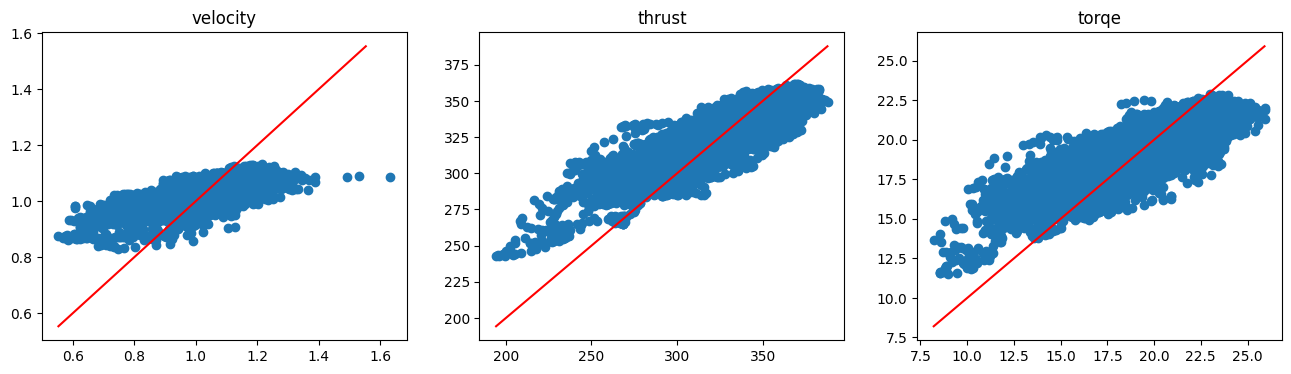

In [4]:
plot_reconstructed(means_preds, targets_means)

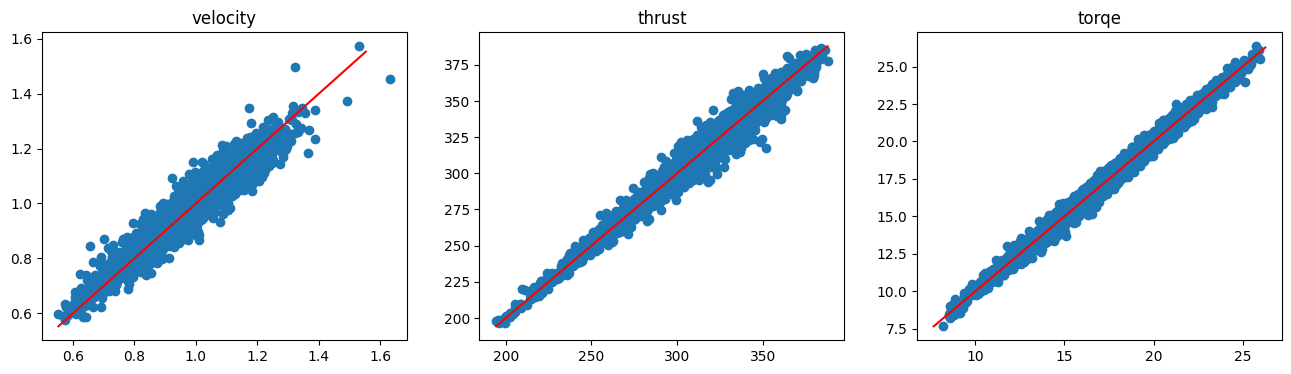

In [5]:
plot_reconstructed(firsts_preds, targets_firsts)

In [6]:
# pred
preds = average_predictions(predictions, batch_size, only_first=False)

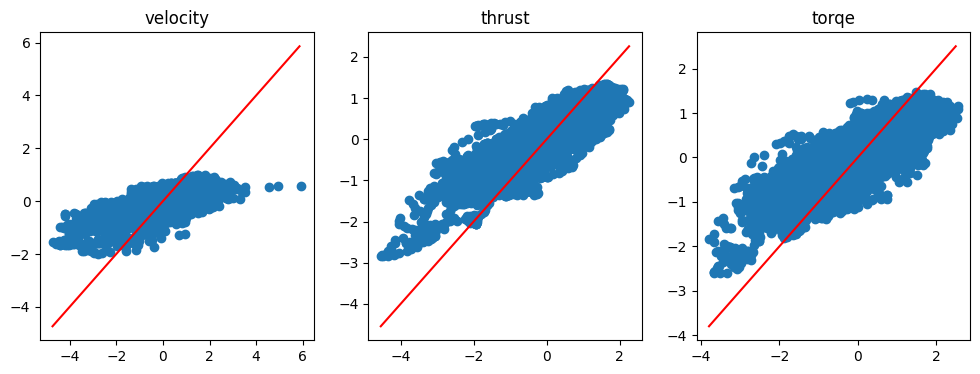

In [8]:
# targets
batch_y_list = []
for batch in test_loader:
    x,y = batch
    batch_y_list.append(y)
    
targets = average_predictions(batch_y_list, batch_size, only_first=True)

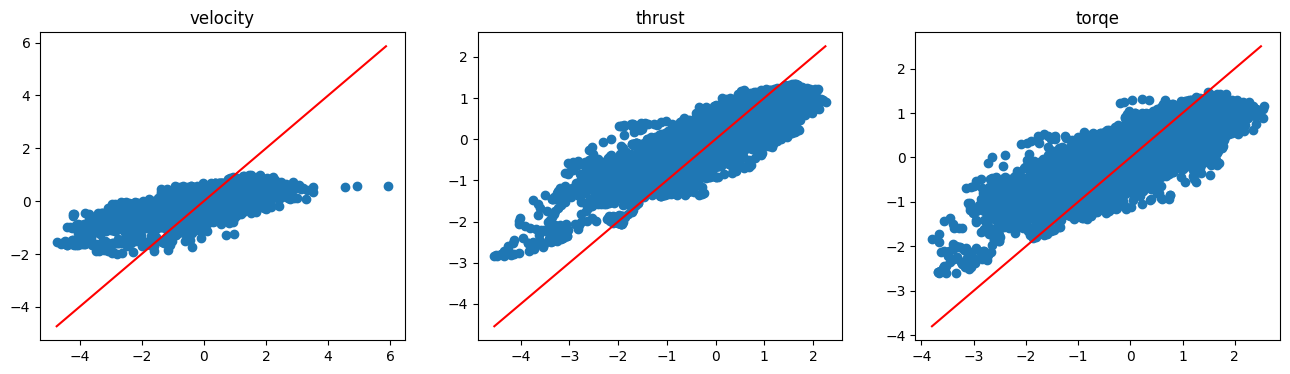

In [9]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16,4))
titles = ['velocity', 'thrust', 'torqe']
for i in range(3):
    min_val = min(np.min(targets[:,i]), np.min(preds[:,i]))
    max_val = max(np.max(targets[:,i]), np.max(preds[:,i]))

    axes[i].scatter(targets[:,i], preds[:,i])

    temp = np.arange(min_val,max_val,0.1)
    axes[i].plot(temp, temp, c='r')

    axes[i].title.set_text(titles[i])

plt.show()

In [16]:
x = [np.array([[1,2],[3,4]]), np.array([[5,6],[7,8]])]
x

[array([[1, 2],
        [3, 4]]),
 array([[5, 6],
        [7, 8]])]

In [17]:
np.mean(x, axis=0)

array([[3., 4.],
       [5., 6.]])